In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [124]:
data = pd.read_csv('dataadd.csv')
hospital_data = data[['D.O.A', 'MRD No.']]

In [125]:
hospital_data['D.O.A'] = pd.to_datetime(hospital_data['D.O.A'], errors='coerce')

C:\Users\DELL\AppData\Local\Temp\ipykernel_1636\500292388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data['D.O.A'] = pd.to_datetime(hospital_data['D.O.A'], errors='coerce')


In [126]:
hospital_data = hospital_data[(hospital_data['D.O.A'].dt.year == 2018)]

In [127]:
hospital_data['MRD No.'] = pd.to_numeric(hospital_data['MRD No.'], errors='coerce')

In [128]:
#daily_admissions = hospital_data.groupby('D.O.A').agg(Total_Admissions=('MRD No.', 'sum')).reset_index()

In [129]:
weekly_admissions_df = daily_admissions.groupby(pd.Grouper(key='D.O.A', freq='W')).agg(Total_Admissions=('Total_Admissions', 'sum')).reset_index()

In [130]:
weekly_admissions_df = weekly_admissions_df.dropna()

In [131]:
weekly_admissions_df.head()

,D.O.A,Total_Admissions
0,2018-01-07,84509413
1,2018-01-14,53441471
2,2018-01-21,12698792
3,2018-01-28,6731209
4,2018-02-04,38183630


In [132]:
weekly_admissions_df.shape

(53, 2)

In [133]:
train_data, test_data = train_test_split(weekly_admissions_df, test_size=0.3, random_state=42)


In [134]:
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 37
Testing set size: 16


In [135]:
lambda_train = train_data['Total_Admissions'].sum() / len(train_data)
print(f"Estimated lambda: {lambda_t_train}")

Estimated lambda: 31693509.75471698


In [136]:
lambda_test = test_data['Total_Admissions'].sum() / len(test_data)
print(f"Lambda Testing Data: {lambda_test}")


Lambda Testing Data: 32646068.125


In [137]:
if abs(lambda_train - lambda_test) / lambda_train < 0.1: 
    print("The process appears homogeneous.")
else:
    print("The process may not be homogeneous.")

The process appears homogeneous.


In [138]:
#Simulated non-homogenous poisson process
def simulate_nhpp(lambda_t):
    simulated_admissions = []
    for rate in lambda_t:
        admissions = np.random.poisson(rate) 
        simulated_admissions.append(admissions)
    return np.array(simulated_admissions)

In [139]:
def simulate_hpp(lambda_rate, num_periods):
    return np.random.poisson(lam=lambda_rate, size=num_periods)

In [140]:
hpp_simulated_admissions = np.random.poisson(lam=lambda_test, size=len(test_data))

In [141]:
test_data['Simulated_Admissions'] = hpp_simulated_admissions

In [142]:
test_data

,D.O.A,Total_Admissions,Simulated_Admissions
19,2018-05-20,5619304,32642060
41,2018-10-21,7042460,32640056
47,2018-12-02,30313426,32645667
12,2018-04-01,26567821,32642845
43,2018-11-04,41312811,32646231
5,2018-02-11,71663903,32648681
17,2018-05-06,57730637,32652825
50,2018-12-23,5841902,32641151
3,2018-01-28,6731209,32648800
32,2018-08-19,4858230,32649865


In [145]:
simulated_data = test_data.copy()
simulated_data['HPP_Simulated_Admissions'] = hpp_simulated_admissions
simulated_data['Tested_Admissions'] = test_data['Total_Admissions']

print(simulated_data[['D.O.A', 'HPP_Simulated_Admissions', 'Tested_Admissions']].head())


        D.O.A  HPP_Simulated_Admissions  Tested_Admissions
19 2018-05-20                  32642060            5619304
41 2018-10-21                  32640056            7042460
47 2018-12-02                  32645667           30313426
12 2018-04-01                  32642845           26567821
43 2018-11-04                  32646231           41312811


1. Interpretation: In this case, the simulated admissions are again significantly higher than the tested admissions. The model seems to consistently predict a much higher number of admissions than what was actually recorded. This could indicate that the simulation's lambda parameter might be set too high or that external factors influencing admissions (e.g., seasonal variations) are not captured well by the model.
2. Overall, comparing the two sets helps identify areas where the simulation is performing well and areas where adjustments might be needed

In [146]:
print("Tested Data Summary:")
test_data['Total_Admissions'].describe()

Tested Data Summary:


count    1.600000e+01
mean     3.264607e+07
std      2.346102e+07
min      4.858230e+06
25%      6.964647e+06
50%      3.163489e+07
75%      5.033149e+07
max      7.289065e+07
Name: Total_Admissions, dtype: float64

In [147]:
print("Simulated Data Summary:")
print(test_data['Simulated_Admissions'].describe())

Simulated Data Summary:
count    1.600000e+01
mean     3.264524e+07
std      3.820018e+03
min      3.263941e+07
25%      3.264265e+07
50%      3.264506e+07
75%      3.264871e+07
max      3.265282e+07
Name: Simulated_Admissions, dtype: float64


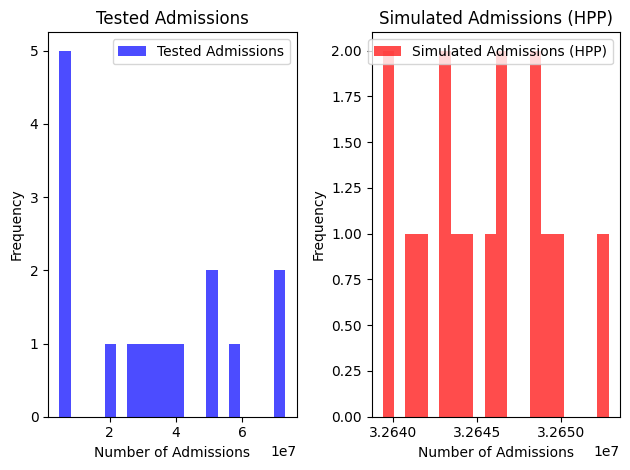

In [149]:
# First subplot: Tested Admissions
plt.subplot(1, 2, 1)  
plt.hist(simulated_data['Tested_Admissions'], bins=20, alpha=0.7, color='blue', label='Tested Admissions')
plt.title('Tested Admissions')
plt.xlabel('Number of Admissions')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Second subplot: Simulated Admissions (HPP)
plt.subplot(1, 2, 2) 
plt.hist(simulated_data['HPP_Simulated_Admissions'], bins=20, alpha=0.7, color='red', label='Simulated Admissions (HPP)')
plt.title('Simulated Admissions (HPP)')
plt.xlabel('Number of Admissions')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
